[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/kadenze-deeplearning-creative-applications/blob/master/Kadenze_Session_3.ipynb)

In [0]:
%matplotlib inline
#%pylab

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.style.use('ggplot')

In [2]:
!git clone https://github.com/JacksonIsaac/CADL.git
!mv CADL/session-3/* .

fatal: destination path 'CADL' already exists and is not an empty directory.
mv: cannot stat 'CADL/session-3/*': No such file or directory


In [0]:
from libs.utils import montage
from libs import gif
from libs.datasets import MNIST

In [4]:
ds = MNIST()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
ds.X.shape

(70000, 784)

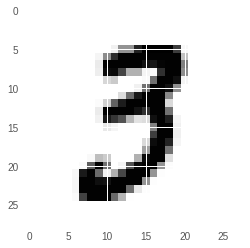

In [6]:
plt.imshow(ds.X[0].reshape((28,28)))

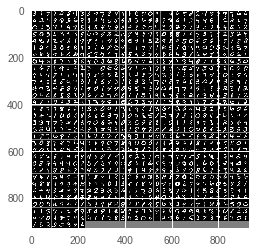

In [7]:
imgs = ds.X[:1000].reshape((-1, 28, 28))
plt.imshow(montage(imgs), cmap='gray')

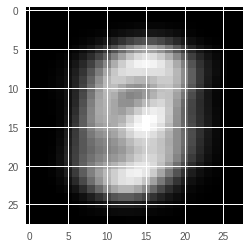

In [8]:
mean_img = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

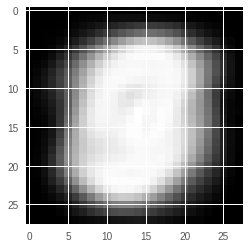

In [9]:
std_img = np.std(ds.X, axis=0)
plt.figure()
plt.imshow(std_img.reshape((28, 28)), cmap='gray')

In [0]:
dimensions = [512, 256, 128, 64]

In [11]:
n_features = ds.X.shape[1]

## [None, n] means that it can have any no of rows m
X = tf.placeholder(tf.float32, [None, n_features])

current_input = X
n_input = n_features


## For decoder
Ws = []

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        
        W = tf.get_variable(
            name = 'W',
            shape = [n_input, n_output],
            initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws = Ws[::-1]

dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]

print(dimensions)

## Encoder

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        
        W = tf.transpose(Ws[layer_i])
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output

[128, 256, 512, 784]
